In [ ]:
# PyData libraries
import numpy as np
rng = np.random.default_rng(seed=42)
from scipy.io import loadmat
from sklearn.manifold import Isomap
from hdbscan import HDBSCAN
import umap.umap_ as umap
import networkx as nx
# Persistence tools
from gtda.plotting import plot_point_cloud
# Plotting
import matplotlib.pyplot as plt
import cv2
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
import dionysus as d

from gudhi import AlphaComplex
from tdafunction import *

At first, we directly follow the Lupo et al.'s approach. Load the pre-saved dataset, which consists of $6040$ points from the conformation space of cyclooctane.

In [16]:
cyclo_octane = loadmat("./dataset/pointsCycloOctane.mat")['pointsCycloOctane']

The circles of singularities can be found by several methods. Traditionally, local PCA was used. Here, we use a singular set found by using methods rooted in local persistent cohomology and used in https://www.pnas.org/content/117/33/19664:

In [17]:
singular_indices = loadmat("./dataset/singularity_indicesCycloOctane_PH0.5.mat")['singularity_indices_PH'].flatten() - 1
nonsingular_indices = np.array([x for x in range(len(cyclo_octane)) if x not in singular_indices])
print(f"{len(singular_indices)} points in the singular set")

627 points in the singular set


Let us store the non-singular portion for later use

In [18]:
nonsingular = cyclo_octane[nonsingular_indices]

A dimensionality reduction algorithm such as Isomap can help us visualize the full dataset in 3D:

In [19]:
isomap = Isomap(n_components=3).fit_transform(cyclo_octane)

In [20]:
plot_point_cloud(isomap, plotly_params={"trace": {"marker_size": 1},
                                        "layout": {"height": 600, "width": 600}})

In [21]:
isomap_nonsingular = isomap[nonsingular_indices]
isomap_singular = isomap[singular_indices]

From previous literature, we expect the nonsingular part of the data to consist of the union of a 2-sphere and a Klein bottle. Hence, we partition the non-singular part using the clustering algorithm HDBSCAN:

In [22]:
HD = HDBSCAN(min_samples=2, min_cluster_size=300, alpha=1., cluster_selection_epsilon=0)
HD.fit(nonsingular)

HDBSCAN(cluster_selection_epsilon=0, min_cluster_size=300, min_samples=2)

With these hyperparameters, the portion we are interested in turns out to be the cluster labelled as `3` by `HDBSCAN`:

In [23]:
mask_klein = HD.labels_ == 3
isomap_klein = isomap_nonsingular[mask_klein]
mask_sphere = np.isin(HD.labels_, [0, 1, 2])
isomap_sphere = isomap_nonsingular[mask_sphere]

We can obtain more evidence that these candidate components are indeed a Klein bottle and a 2-sphere by computing persistent homology of the corresponding 24-dimensional point clouds.

In [24]:
klein = nonsingular[mask_klein]
sphere = nonsingular[mask_sphere]

We subsample 500 points from the point cloud that is presumed to lie on the Klein bottle and embed them into a 6-dimensional Euclidean space using the UMAP algorithm.

In [25]:
subklein = farthest_subarray(klein,500)
umap_reducer = umap.UMAP(n_components=6, n_neighbors=30, min_dist=0.1, metric='euclidean')
subklein_umap = umap_reducer.fit_transform(subklein)
#maximum = max([np.linalg.norm(subklein_umap[i]) for i in range(len(subklein_umap))])
#subklein_umap /= maximum

points = subklein_umap

We draw a persistent diagram over $\mathbb{Z}/2.$

Alpha complex is of dimension  6  -  8817331  simplices -  500  vertices.


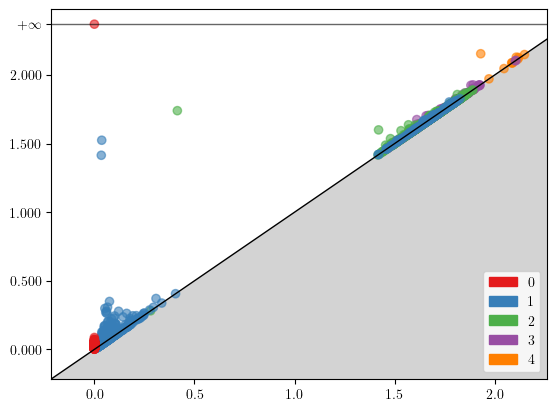

In [26]:
# Construct alpha complex using Gudhi
ac = AlphaComplex(points = points) 
stree = ac.create_simplex_tree()
print('Alpha complex is of dimension ', stree.dimension(), ' - ',
  stree.num_simplices(), ' simplices - ', stree.num_vertices(), ' vertices.')
diag = stree.persistence(homology_coeff_field=2, persistence_dim_max=3)
gd.plot_persistence_diagram(diag)
plt.xlabel("")
plt.ylabel("")
plt.title("")
plt.show()

We find the persistent Stiefel-Whitney classes of type $2$ on filtration range $[0.7,1.3]$.

In [27]:
s = 0.7
t = 1.3
value = 1.3
value_stree = ac.create_simplex_tree(max_alpha_square=value)
fsimplices = []
for fspx in value_stree.get_filtration():
        fsimplices.append(fspx)
f = d.Filtration(fsimplices)
cm = d.cohomology_persistence(f,prime=2)
cdgms = d.init_diagrams(cm,f)

In [28]:
sw1 = pers_sw_class(f,1,2,s,t)
sw2 = pers_sw_class(f,2,2,s,t)

idx1 = kth_longest_index(cdgms, 1, 1)
idx2 = kth_longest_index(cdgms, 1, 2)
idx3 = kth_longest_index(cdgms, 2, 1)

cocycle1 = get_cocycles(cm,f,cdgms, 1, idx1)
cocycle2 = get_cocycles(cm,f,cdgms, 1, idx2)
cocycle3 = get_cocycles(cm,f,cdgms, 2, idx3)

cob_mat1 = coboundary_matrix(f,1)
cob_mat2 = coboundary_matrix(f,2)

In [29]:
is_cohomologous(cob_mat1,cocycle1,sw1)

False

In [30]:
is_cohomologous(cob_mat1,cocycle2,sw1)

False

In [31]:
cocycle4 = sum_cocycles([cocycle1, cocycle2])
is_cohomologous(cob_mat1, cocycle4, sw1)

True

In [32]:
is_cohomologous(cob_mat2,cocycle3,sw2)

False

In [33]:
zero_cohomologous(cob_mat2,sw2)

True

In [34]:
stree = ac.create_simplex_tree()
fsimplices = []
for fspx in stree.get_filtration():
        fsimplices.append(fspx)
f = d.Filtration(fsimplices)
cm = d.cohomology_persistence(f,prime=2)
cdgms = d.init_diagrams(cm,f)

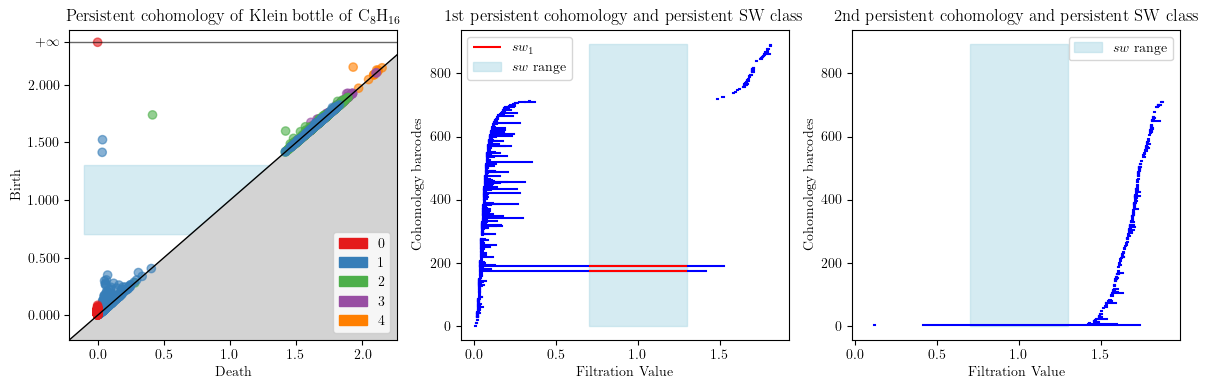

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

gd.plot_persistence_diagram(diag,axes=axes[0])
axes[0].set_title("Persistent cohomology of Klein bottle of $\mathrm{C_8H_{16}}$")
axes[0].fill([-0.1,-0.1,t,s],[s,t,t,s], color = 'lightblue', alpha=0.5, label = 'SW range')
axes[0].set_xlabel('Death',size=10)
axes[0].set_ylabel('Birth',size=10)
#axes[0].legend()

d.plot.plot_bars(cdgms[1],ax=axes[1])
axes[1].hlines(np.array([idx1,idx2]),s,t,colors="red",label="$sw_1$")
axes[1].set_title("1st persistent cohomology and persistent SW class")
axes[1].set_xlabel('Filtration Value')
axes[1].set_ylabel('Cohomology barcodes')
axes[1].fill([s,s,t,t],[0,len(cdgms[1]),len(cdgms[1]),0], color = 'lightblue', alpha=0.5, label = '$sw$ range')
axes[1].legend()


d.plot.plot_bars(cdgms[2],ax=axes[2])
axes[2].set_title("2nd persistent cohomology and persistent SW class")
axes[2].fill([s,s,t,t],[0,len(cdgms[1]),len(cdgms[1]),0], color = 'lightblue', alpha=0.5, label = '$sw$ range')
axes[2].set_xlabel('Filtration Value')
axes[2].set_ylabel('Cohomology barcodes')
axes[2].legend()

fig.tight_layout()
plt.show()